### import packages
when running in EXPANSE, do not import plotting packages since they are not allowed

In [ ]:
import netCDF4
import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from matplotlib.colors import LogNorm
import numpy as np

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### this is a test to interopolate a single chl file to WOA13 grid

In [21]:
from scipy.interpolate import RegularGridInterpolator
nitrate_file_path = '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/woa13_all_n01_01.nc'


# Open the chlorophyll file using xarray
ds_chl = xr.open_dataset(chl_file_path, engine='netcdf4')
ds_chl = ds_chl.sortby('lat')

# Open the nitrate file to get the target longitude and latitude grid
ds_nitrate = xr.open_dataset(nitrate_file_path, engine='netcdf4', decode_times=False)

# Access the latitude, longitude, and chlorophyll  variables
chl_lat = ds_chl['lat'].values # 180 * 1
chl_lon = ds_chl['lon'].values # 360 * 1
chl_data = ds_chl['chlor_a'].values # 360 * 180 

# Access the target latitude and longitude from the nitrate dataset
target_lat = ds_nitrate['lat'].values
target_lon = ds_nitrate['lon'].values

# Create a meshgrid for the target coordinates
target_lon_grid, target_lat_grid = np.meshgrid(target_lon, target_lat)


interpolator = RegularGridInterpolator((chl_lat, chl_lon), chl_data, method='linear', bounds_error=False, fill_value=np.nan)
target_lon_grid, target_lat_grid = np.meshgrid(target_lon, target_lat)
target_points = np.array([target_lat_grid.flatten(), target_lon_grid.flatten()]).T
chl_interpolated = interpolator(target_points).reshape(target_lat_grid.shape)


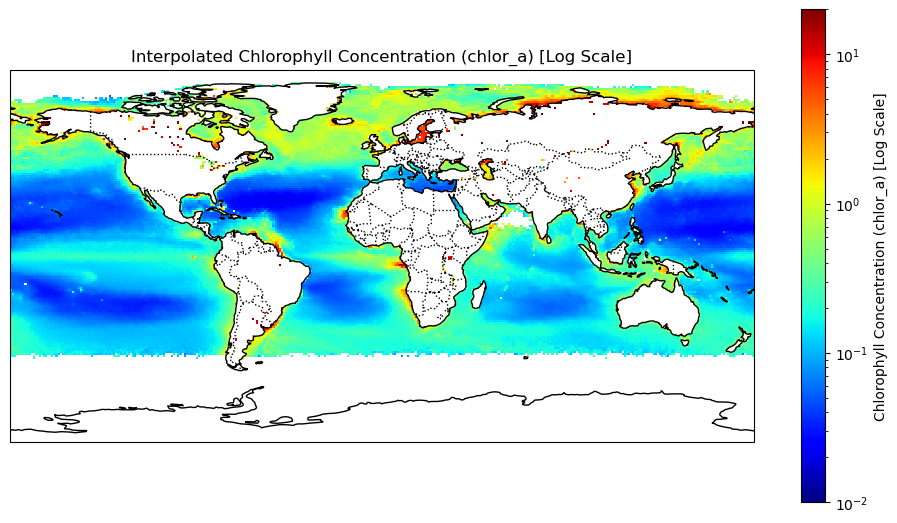

In [22]:
# Plot the interpolated chlorophyll data
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
pcm = ax.pcolormesh(target_lon_grid, target_lat_grid, chl_interpolated, cmap='jet', norm=LogNorm(vmin=0.01, vmax=20))
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Chlorophyll Concentration (chlor_a) [Log Scale]')
ax.set_title('Interpolated Chlorophyll Concentration (chlor_a) [Log Scale]')
plt.show()

### This is a test to interpolate chl files at all months into WOA13 grid

In [ ]:
# nitrate_file_path = r'C:\Users\LMS-youranl\Downloads\woa13_all_n00_01.nc'
# chl_file_path = r'C:\Users\LMS-youranl\Downloads\data\CHL\AQUA_MODIS.20020701_20210731.L3m.MC.CHL.chlor_a.9km.nc'

import os
import re
# Paths to the directories and files
chl_dir_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_data/CHL/'
nitrate_file_path = '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/woa13_all_n01_01.nc'

# List all chlorophyll files
chl_files = [os.path.join(chl_dir_path, f) for f in os.listdir(chl_dir_path) if f.endswith('.nc')]

# Extract month from each filename and sort the files by month
def extract_month(filename):
    match = re.search(r'\d{8}', filename)
    if match:
        date_str = match.group(0)
        return int(date_str[4:6])  # Extract the month part
    return None

# Create a sorted list of files based on the extracted month
chl_files_sorted = sorted(chl_files, key=extract_month)
print(chl_files_sorted)

# Ensure there are exactly 12 files for 12 months
assert len(chl_files_sorted) == 12, "There should be exactly 12 files for 12 months."

# Open the nitrate file to get the target longitude and latitude grid
ds_nitrate = xr.open_dataset(nitrate_file_path, engine='netcdf4', decode_times=False)
target_lat = ds_nitrate['lat'].values # 180 * 1
target_lon = ds_nitrate['lon'].values # 360 * 1
nitrate = ds_nitrate['n_an'].values  # 360 * 180 


target_lon_grid, target_lat_grid = np.meshgrid(target_lon, target_lat)

# Prepare the array to hold the interpolated data for 12 months
interpolated_data = np.empty((len(target_lat), len(target_lon), 12))

from scipy.interpolate import RegularGridInterpolator
# Process and interpolate each chlorophyll file
for i, chl_file_path in enumerate(chl_files_sorted):
    # Open the chlorophyll file using xarray
    ds_chl = xr.open_dataset(chl_file_path, engine='netcdf4')
    ds_chl = ds_chl.sortby('lat')

    # Access the latitude, longitude, and chlorophyll (chlor_a) variables
    chl_lat = ds_chl['lat'].values
    chl_lon = ds_chl['lon'].values
    chl_data = ds_chl['chlor_a'].values

    # Perform the interpolation using RegularGridInterpolator
    interpolator = RegularGridInterpolator((chl_lat, chl_lon), chl_data, method='linear', bounds_error=False, fill_value=np.nan)
    target_points = np.array([target_lat_grid.flatten(), target_lon_grid.flatten()]).T
    chl_interpolated = interpolator(target_points).reshape(target_lat_grid.shape)

    # Store the interpolated data in the 3D array
    interpolated_data[:, :, i] = chl_interpolated  # Use the sorted order to map to correct month

# Verify the shape of the combined data
print('Shape of the interpolated data:', interpolated_data.shape)


In [23]:
nitrate_file_path = r'C:\Users\LMS-youranl\Downloads\woa13_all_n00_01.nc'
ds_nitrate = xr.open_dataset(nitrate_file_path, engine='netcdf4', decode_times=False)
target_lat = ds_nitrate['lat'].values # 180 * 1
target_lon = ds_nitrate['lon'].values # 360 * 1
nitrate = ds_nitrate['n_an'].values  # 360 * 180 

In [24]:
ds_nitrate

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 6.0
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    n_an                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    n_mn                (time, depth, lat, lon) float32 ...
    n_dd                (time, depth, lat, lon) float64 ...
    n_sd                (time, depth, lat, lon) float32 ...
    n_se                (time, depth, lat, lon) float32 ...
    n_oa                (time, depth, lat, lon) float32 ...
    n_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2013 version 2 : moles...
    summary:                         Climatological mean dissolved inorganic ...
    references:                       Garcia H. E., T. P. Boyer, R. A. Locarn...
    institution:                     National Oceanographic Data Center(NODC)
    comment:                         global climatology as part of the World ...
    ...                              ...
    nodc_template_version:           NODC_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA13/pr_wo...
    date_created:                    2011-09-28 
    date_modified:                   2011-09-28

### RUN THIS to Interpolate multiple variables at all months into WOA13 grid

In [ ]:
import os
import re
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import netCDF4
import xarray as xr

# Paths to the directories
base_dir = '/expanse/lustre/projects/unc107/yli39/data/satellite_data/'
variables = ['CHL', 'APH', 'FLU', 'PIC', 'POC', 'PAR', 'SST']
nitrate_file_path = '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/woa13_all_n01_01.nc'

# Open the nitrate file to get the target longitude and latitude grid
ds_nitrate = xr.open_dataset(nitrate_file_path, engine='netcdf4', decode_times=False)
target_lat = ds_nitrate['lat'].values
target_lon = ds_nitrate['lon'].values
target_lon_grid, target_lat_grid = np.meshgrid(target_lon, target_lat)

# Prepare the array to hold the interpolated data for 7 variables, 12 months
num_lons, num_lats = target_lon_grid.shape
interpolated_data = np.empty((7, num_lons, num_lats, 12))

# Function to extract month from filename
def extract_month(filename):
    match = re.search(r'\d{8}', filename)
    if match:
        date_str = match.group(0)
        return int(date_str[4:6])  # Extract the month part
    return None


# Process each variable
for var_idx, var in enumerate(variables):
    var_dir_path = os.path.join(base_dir, var)
    chl_files = [os.path.join(var_dir_path, f) for f in os.listdir(var_dir_path) if f.endswith('.nc')]

    # Sort the files by month
    chl_files_sorted = sorted(chl_files, key=extract_month)
    
    # Ensure there are exactly 12 files for 12 months
    assert len(chl_files_sorted) == 12, f"There should be exactly 12 files for 12 months in {var_dir_path}."

    # Process and interpolate each chlorophyll file
    for i, chl_file_path in enumerate(chl_files_sorted):
        # Open the chlorophyll file using xarray
        ds_chl = xr.open_dataset(chl_file_path, engine='netcdf4')
        ds_chl = ds_chl.sortby('lat')

        # Access the latitude, longitude, and chlorophyll variables
        chl_lat = ds_chl['lat'].values
        chl_lon = ds_chl['lon'].values
        chl_data = ds_chl.data_vars[list(ds_chl.data_vars.keys())[0]].values  # Assuming the first variable is the required one

        # Perform the interpolation using RegularGridInterpolator
        interpolator = RegularGridInterpolator((chl_lat, chl_lon), chl_data, method='linear', bounds_error=False, fill_value=np.nan)
        target_points = np.array([target_lat_grid.flatten(), target_lon_grid.flatten()]).T
        chl_interpolated = interpolator(target_points).reshape(target_lat_grid.shape)

        # Store the interpolated data in the 4D array
        interpolated_data[var_idx, :, :, i] = chl_interpolated

# Verify the shape of the combined data
print('Shape of the interpolated data:', interpolated_data.shape)

In [ ]:
output_file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_data/interpolated_data.nc'
# Create an xarray Dataset to store the interpolated data
# Create an xarray Dataset to store the interpolated data
data_vars = {var: (['lat', 'lon', 'month'], interpolated_data[var_idx]) for var_idx, var in enumerate(variables)}
coords = {
    'lat': target_lat,
    'lon': target_lon,
    'month': np.arange(1, 13)
}
dataset = xr.Dataset(data_vars, coords)

# Save the dataset to a NetCDF file
dataset.to_netcdf(output_file_path)

# Verify the shape of the combined data
print('Shape of the interpolated data:', interpolated_data.shape)
print(f"Interpolated data has been saved to {output_file_path}")

### Plot variables on WOA13 grid in Jan. only run the following in local jupyternotebook

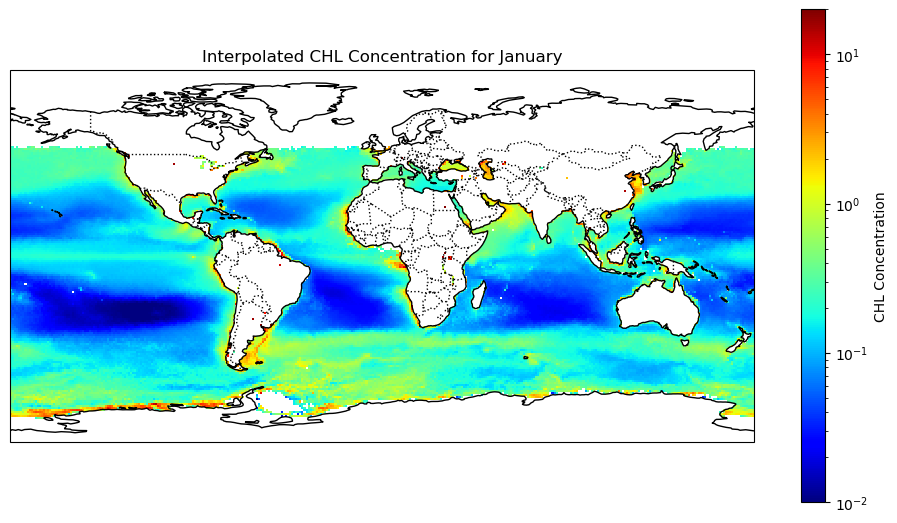

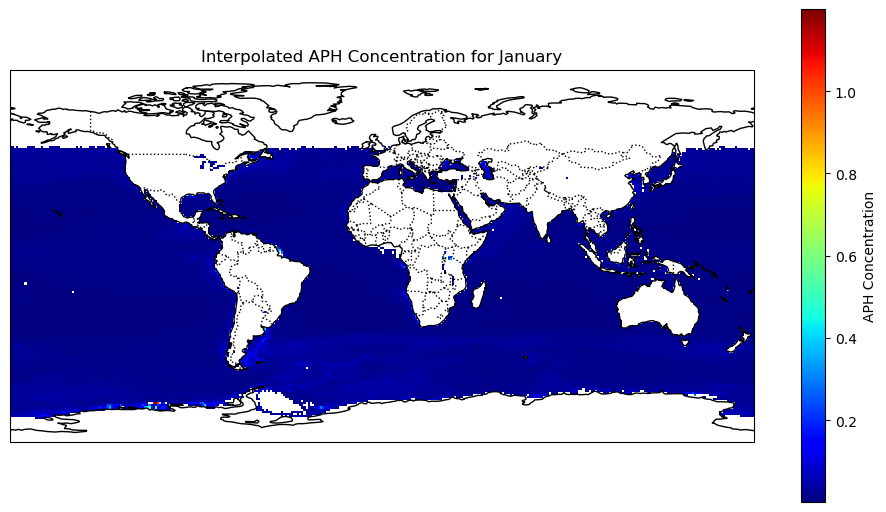

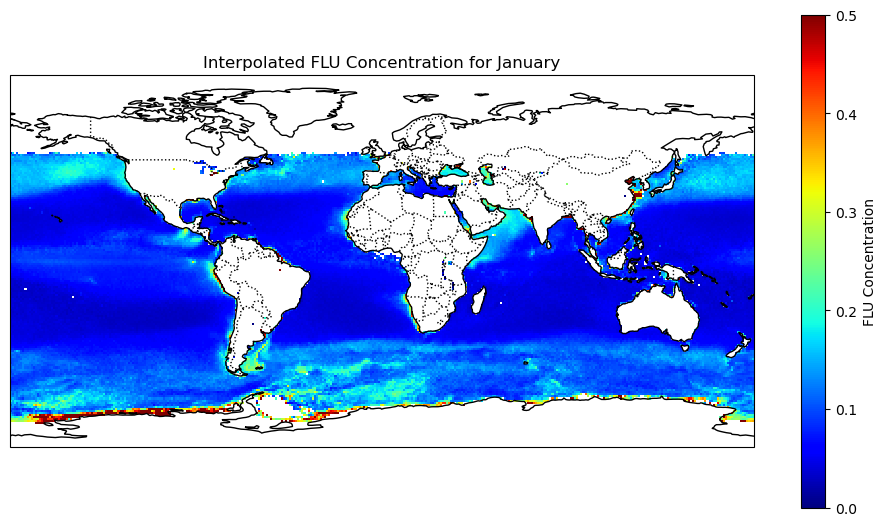

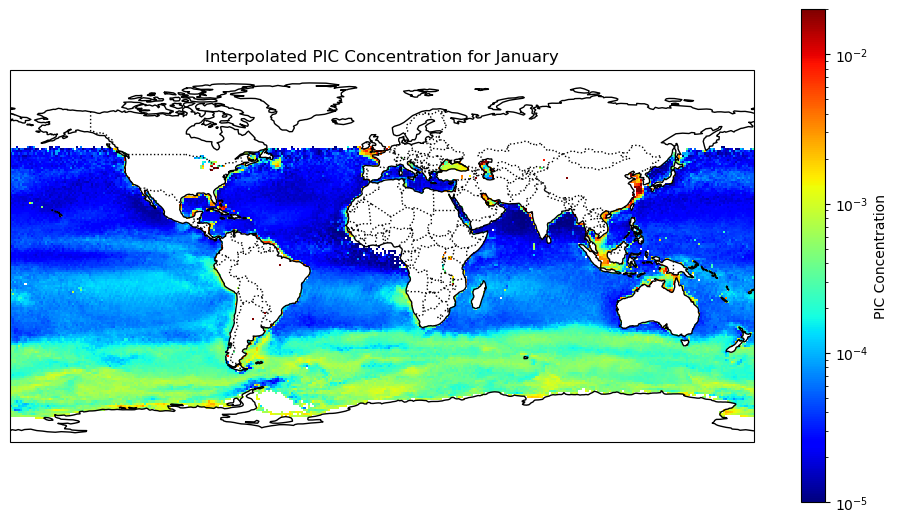

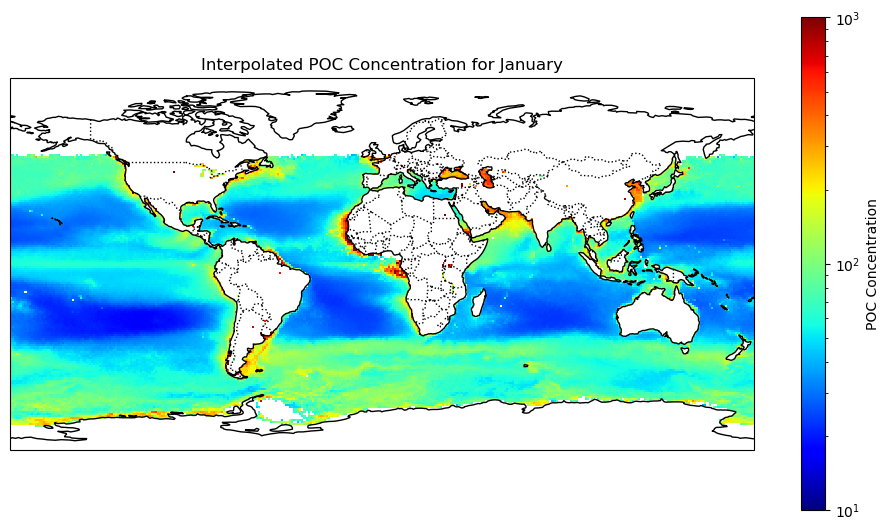

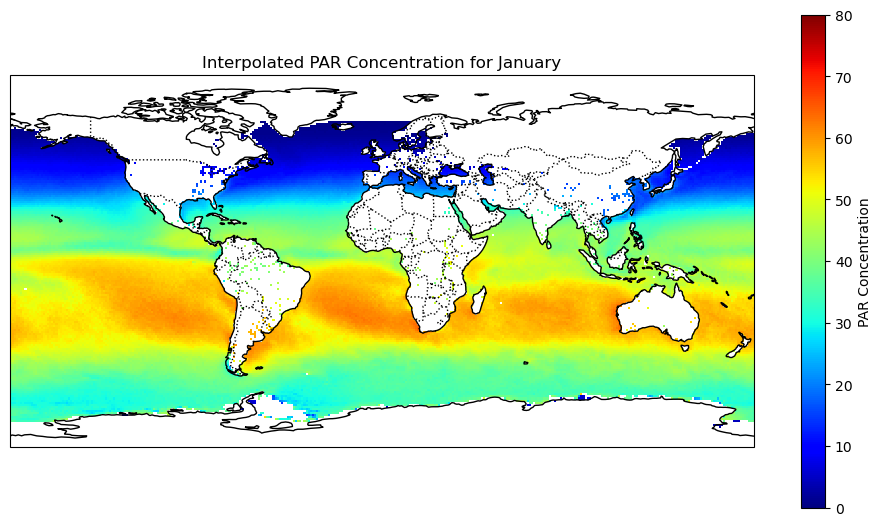

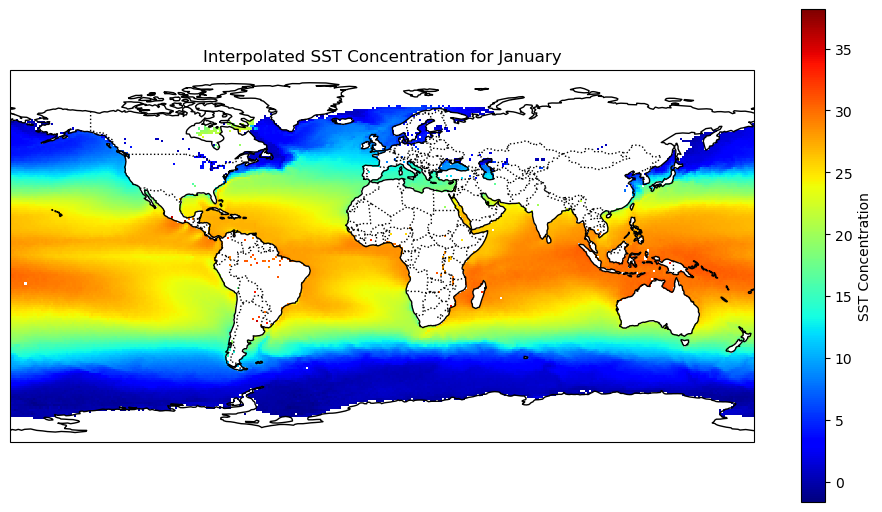

Figures have been saved to C:\Users\LMS-youranl\Downloads\data


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
import os

# Path to the interpolated data file
interpolated_file_path = r'C:\Users\LMS-youranl\Downloads\data\interpolated_data.nc'

# Path to the directory where figures will be saved
output_dir = r'C:\Users\LMS-youranl\Downloads\data'

# Open the interpolated data file using xarray
ds = xr.open_dataset(interpolated_file_path)

# List of variables to plot
variables = ['CHL', 'APH', 'FLU', 'PIC', 'POC', 'PAR', 'SST']

# Plotting each variable for January and saving the figures
for var in variables:
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data = ds[var].sel(month=1)
    
    if var == 'CHL':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=0.01, vmax=20))
    elif var == 'FLU':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', vmin=0, vmax=0.5)
    elif var == 'PAR':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', vmin=0, vmax=80)
    elif var == 'PIC':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=1e-5, vmax=0.02))
    elif var == 'POC':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=10, vmax=1000))
    else:
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet')
        
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(f'{var} Concentration')
    ax.set_title(f'Interpolated {var} Concentration for January')

    # Save the figure
    output_path = os.path.join(output_dir, f'{var}_January.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()

print(f"Figures have been saved to {output_dir}")


### this is the end

### thie is a test to plot data at original grid before being interpolated into WOA13 grid

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20020701_20210731.L3m.MC.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        4531938
    data_minimum:                     0.0039563533
    data_maximum:                     85.53398

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

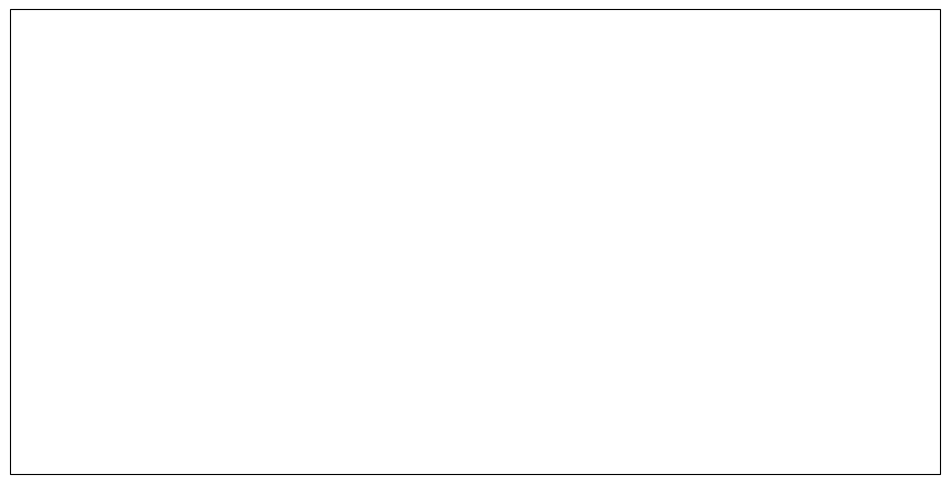

In [9]:
# Path to the NetCDF file
# file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_data/CHL/AQUA_MODIS.20020701_20210731.L3b.MC.CHL.nc'
# file_path = r'C:\Users\LMS-youranl\Downloads\CHL\AQUA_MODIS.20020701_20210731.L3b.MC.CHL.nc'
# file_path = r'C:\Users\LMS-youranl\Downloads\CHL\AQUA_MODIS_20020701_20210731_L3b_MC_CHL.nc'
# file_path = r'C:\Users\LMS-youranl\Downloads\CHL\AQUA_MODIS_20020701_20210731_L3b_MC_CHL.nc'
# file_path = r'C:\Users\LMS-youranl\Downloads\data\SST\AQUA_MODIS.20020701_20220731.L3m.MC.SST.sst.9km.nc'

file_path = r'C:\Users\LMS-youranl\Downloads\data\CHL\AQUA_MODIS.20020701_20210731.L3m.MC.CHL.chlor_a.9km.nc'

# file_path = r'C:\Users\LMS-youranl\Downloads\data\CHL\AQUA_MODIS.20020701_20210731.L3m.MC.CHL.chlor_a.4km.nc'

ds = xr.open_dataset(file_path, engine='netcdf4')  # on a 1/12 degree grid
display(ds)


# Access the latitude, longitude, and chlorophyll (aph_443) variables
chl_lat = ds['lat'].values
chl_lon = ds['lon'].values
chl = ds['chlor_a'].values

# Plot the chlorophyll data on a map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
pcm = chl.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='jet',
    x='lon',
    y='lat',
    norm=LogNorm(vmin=0.01, vmax=20),
    add_colorbar=False
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Chlorophyll Concentration')
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.6)  # Shrink the colorbar by 80%
plt.show()